**Goal**: Compute descriptive info on the dataset of quantum programs.

# Dataset Statistics (Qiskit and Cirq)

In [9]:
import project_path
from rdlib import *  # this imports the base libraries

import glob
from typing import Dict, List
import re


In [31]:
# dataset
DIR_DATASET_QISKIT = '../data/datasets/exp_v08'
DIR_DATASET_CIRQ = '../data/datasets/exp_v07'

# output
PAPER_DIR = '../data/paper_images'

# Abstraction
DETECTORS_FOLDER = '../qlint/codeql/src'
ABSTRACTION_FOLDER = '../qlint/codeql/lib/qiskit'

# warning & manual inspection
PATH_WARNINGS_SARIF = '../data/analysis_results/exp_v08/codeql_2023-03-13_13-54-00/data.sarif'
PATH_MANUAL_INSPECTION_CSV = '../data/annotations/manual_inspection/warnings_until_23_03_21.csv'
PATH_METADATA_DATASET = '../data/datasets/exp_v08/df_summary.csv'

# BLACKLIST OF DATA WHICH REFER TO OBSOLETE INSPECTIONS/ IMPLEMENTATIONS
BLACKLIST_EXPERIMENTS = ['exp_v00']
BLACKLISTED_QUERIES = ['/Vulnerability/TokenLeakage.ql']
BLACKLISTED_RULES = ['ql-token-leakage']
BLACKLISTED_ABSTRACTION = ['/SensitiveAPI.qll']

# NAME MAPPING
RULE_NAME_MAPPING = {
    'ql-ghost-compose': 'GhostCompose',
    'ql-measure-all-abuse': 'MeasAllAbuse',
    'ql-operation-after-measurement': 'OpAfterMeas',
    'ql-op-after-optimization': 'OpAfterOpt',
    'ql-oversized-circuit': 'OversizedCircuit',
    'ql-double-measurement': 'DoubleMeas',
    'ql-unmeasurable-qubits': 'UnmeasQubits',
    'ql-ungoverned-composition': 'UngovCompose',
    'ql-incompatible-composition': 'IncompCompose',
    'qsmell-nc': 'QSmellNC',
    'qsmell-lpq': 'QSmellLPQ',
}

In [11]:
import os

def get_file_extension_dictionary(dir: str) -> dict:
    """Get a dictionary {filename: its extension, etc.} form a directory."""
    file_extensions = {}
    for file in os.listdir(dir):
        base_name = os.path.splitext(file)[0]
        extension = os.path.splitext(file)[1]
        file_extensions[base_name] = extension
    return file_extensions

def create_pandas(file_extensions: dict) -> pd.DataFrame:
    """Create a pandas dataframe from a dictionary {filename: its extension, etc.}."""
    df = pd.DataFrame.from_dict(file_extensions, orient='index', columns=['extension'])
    df['filename'] = df.index
    # drop index
    df.reset_index(drop=True, inplace=True)
    df['filename'] = df['filename'].astype(str)
    df['extension'] = df['extension'].astype(str)
    return df


In [12]:
def get_stats_on(dataset_folder: str, platform_name: str):
    """Print the summary stats of the given folder."""

    ext_dict_selected = get_file_extension_dictionary(
        dir=os.path.join(dataset_folder, 'files_selected'))
    df_selected = create_pandas(ext_dict_selected)

    ext_dict_all = get_file_extension_dictionary(
        dir=os.path.join(dataset_folder, 'raw_files'))
    df_all = create_pandas(ext_dict_all)

    df_merged = pd.merge(
        df_selected, df_all, 
        on='filename', how='left',
        suffixes=('_selected', '_all'))

    # countplot with percentage of py and ipynb files
    total_unique_files = df_merged.shape[0]
    total_raw_files = df_all.shape[0]
    perc_py = (df_merged[df_merged['extension_all'] == '.py'].shape[0] / total_unique_files) * 100
    perc_ipynb = (df_merged[df_merged['extension_all'] == '.ipynb'].shape[0] / total_unique_files) * 100
    print(f'Percentage of .py files: {perc_py:.1f} %')
    print(f'Percentage of .ipynb files: {perc_ipynb:.1f} %')
    print(f'Total unique files: {total_unique_files}')
    print(f'Total files (scraped): {total_raw_files}')

    print("\\newcommand{\\nProgramsScraped" + platform_name + "}{" + f"{total_raw_files:,}" + "}")
    print("\\newcommand{\\nProgramsSelected" + platform_name + "}{" + f"{total_unique_files:,}" + "}")
    print("\\newcommand{\\nProgramsPy" + platform_name + "}{" + f"{perc_py:.1f}" + "\%}")
    print("\\newcommand{\\nProgramsIpynb" + platform_name + "}{" + f"{perc_ipynb:.1f}" + "\%}")
    
    fig, ax = plt.subplots(figsize=(5, 1.5))
    sns.countplot(
        data=df_merged, 
        y='extension_all',
        order=['.py', '.ipynb'],
        ax=ax,
    )
    plt.xlabel('Number of programs')
    plt.ylabel('Extension')
    plt.tight_layout()
    fig.savefig(
        os.path.join(PAPER_DIR, f'files_per_extension_{platform_name}.pdf'))
    


Percentage of .py files: 85.8 %
Percentage of .ipynb files: 14.2 %
Total unique files: 7568
Total files (scraped): 81862
\newcommand{\nProgramsScrapedQiskit}{81,862}
\newcommand{\nProgramsSelectedQiskit}{7,568}
\newcommand{\nProgramsPyQiskit}{85.8\%}
\newcommand{\nProgramsIpynbQiskit}{14.2\%}


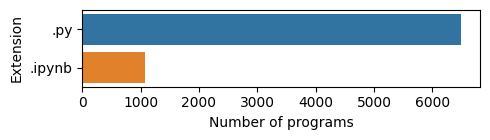

In [13]:
get_stats_on(
    dataset_folder=DIR_DATASET_QISKIT,
    platform_name='Qiskit')

Percentage of .py files: 89.3 %
Percentage of .ipynb files: 10.7 %
Total unique files: 2000
Total files (scraped): 20211
\newcommand{\nProgramsScrapedCirq}{20,211}
\newcommand{\nProgramsSelectedCirq}{2,000}
\newcommand{\nProgramsPyCirq}{89.3\%}
\newcommand{\nProgramsIpynbCirq}{10.7\%}


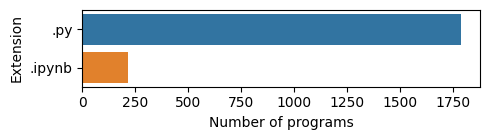

In [14]:
get_stats_on(
    dataset_folder=DIR_DATASET_CIRQ,
    platform_name='Cirq')

## RQ1: Modeling Info: Abstractions and Queries
- How many CodeQL LoC per checker. 
- Avg number of abstractions used. >> bipartite graph.


In [9]:
def read_files(folder: str, extension: str = ".ql") -> Dict[str, str]:
    """Read all files with the given extension in the folder and subfolders."""
    ql_files = {}
    for file in glob.glob(folder + f'/**/*{extension}', recursive=True):
        with open(file, 'r') as f:
            content = f.read()
            ql_files[file.replace(folder, "")] = content
    return ql_files

def get_abstractions_used(content: str) -> List[str]:
    """Get the abstractions used in the given content."""
    abstractions = []
    for line in content.splitlines():
        if line.startswith('import'):
            abstraction = line.split(' ')[1]
            abstractions.append(abstraction)
    return abstractions

In [6]:
query_files = read_files(
    folder=DETECTORS_FOLDER, extension='.ql')
abstraction_files = read_files(
    folder=ABSTRACTION_FOLDER, extension='.qll')

# remove all the blacklisted queries
query_files = {
    k: v for k, v in query_files.items() 
    if k not in BLACKLISTED_QUERIES}

# remove all the blacklisted abstractions
abstraction_files = {
    k: v for k, v in abstraction_files.items() 
    if k not in BLACKLISTED_ABSTRACTION}

print(f'Number of queries: {len(query_files)}')
print(f'Number of abstractions: {len(abstraction_files)}')
all_query_names = list(query_files.keys())
print(all_query_names)

all_abstractions_names = list(abstraction_files.keys())
print(all_abstractions_names)

Number of queries: 13
Number of abstractions: 6
['/Measurement/OpAfterMeasurement.ql', '/Measurement/MeasureAll.ql', '/Measurement/DoubleMeasurement.ql', '/Qsmell/NoAlignmentLogicalPhysical.ql', '/Qsmell/NonParametrizedCircuit.ql', '/Resource/OversizedCircuit.ql', '/Resource/UnmeasurableQubits.ql', '/Simulation/InvalidPauliSyntaxError.ql', '/Simulation/InvalidPauliErrorSize.ql', '/Interconnection/IncompatibleComposition.ql', '/Interconnection/UngovernedComposition.ql', '/Interconnection/GhostComposition.ql', '/Optimization/OpAfterOptimization.ql']
['/Register.qll', '/Qubit.qll', '/Pauli.qll', '/NoiseModel.qll', '/Circuit.qll', '/Gate.qll']


### RQ1.A Abstractions and Qiskit API mapping 

In [24]:
import re

PATH_MAPPING_TABLE_CSV = "mapping_table.csv"
df = pd.read_csv(PATH_MAPPING_TABLE_CSV)
latex_table = df.to_latex(index=False)
# replace all NaN with empty space
latex_table = re.sub(r'NaN', '', latex_table)
# replace anything between two stars with a highlight
lines = latex_table.splitlines()
new_lines = []
for i, line in enumerate(lines):
    # whenever the line starts with a letter, add a midrule
    if re.findall(r'^[a-zA-Z]', line.strip()):
        #print(line.strip())
        new_lines.append('\\midrule')
    new_line = line
    new_line = new_line.replace('*', '\\hl{', 1)
    new_line = new_line.replace('*', '}', 1)
    new_lines.append(new_line)
latex_table = '\n'.join(new_lines)
# convert \toprule\n\midrule to \toprule
latex_table = latex_table.replace('\\toprule\n\\midrule', '\\toprule')
# convert \midrule\n\midrule to \midrule
latex_table = latex_table.replace('\\midrule\n\\midrule', '\\midrule')

print(latex_table)
df.head()

\begin{tabular}{lllll}
\toprule
   Our Abstraction &                                         Qiskit API &                Our Methods &         Result & Cardinality \\
\midrule
          Register &                        qreg = \hl{QuantumRegister}(3) &                  getSize() &              3 &      single \\
                   &                      creg = \hl{ClassicalRegister}(2) &      hasIntegerParameter() &           true &      single \\
                   &                          qX = \hl{QuantumRegister}(2) &    getAnAccessedPosition() &              0 &    multiple \\
                   &                          qY = \hl{QuantumRegister}(1) &                   getVar() &             qY &      single \\
\midrule
   Quantum Circuit &              qc = \hl{QuantumCircuit}(qreg, qX, creg) &        getNumberOfQubits() &              6 &      single \\
                   &                                                 &      getAQuantumRegister() & [qreg, qX, qY] &         

/tmp/ipykernel_43146/3205909820.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=False)


,Our Abstraction,Qiskit API,Our Methods,Result,Cardinality
0,Register,qreg = *QuantumRegister*(3),getSize(),3,single
1,,creg = *ClassicalRegister*(2),hasIntegerParameter(),true,single
2,,qX = *QuantumRegister*(2),getAnAccessedPosition(),0,multiple
3,,qY = *QuantumRegister*(1),getVar(),qY,single
4,Quantum Circuit,"qc = *QuantumCircuit*(qreg, qX, creg)",getNumberOfQubits(),6,single


### RQ1.C Which abstractions are used in the different queries?

In [7]:
def get_abstractions_from_qll(content: str) -> List[str]:
    """Get the abstractions used in the given content.
    
    It uses regex."""
    # all_abstractions = re.findall(r'class (\w+)', content)
    public_abstractions = re.findall(r'^class (\w+)', content, re.MULTILINE)
    return public_abstractions

all_abstraction_defined = []
for abstraction_file in abstraction_files.values():
    all_abstraction_defined += get_abstractions_from_qll(abstraction_file)

print(f'Number of abstractions defined: {len(all_abstraction_defined)}')
print(all_abstraction_defined)

Number of abstractions defined: 11
['ClassicalRegister', 'QuantumRegister', 'QubitUsedInteger', 'PauliString', 'PauliError', 'QuantumCircuit', 'TranspiledCircuit', 'Gate', 'MeasureGate', 'MeasurementAll', 'MeasurementAny']


In [8]:
def check_abstractions_used(abstraction: List[str], content: str) -> bool:
    """Check if the given abstraction is used in the content.
    
    Via regex.
    """
    abstractions_used = []
    for a in abstraction:
        if re.search(rf'\b{a}\b', content):
            abstractions_used.append(a)
    return abstractions_used


query_to_abstraction = {}
mapping_renaming = {
    'InvalidPauliSyntaxError': 'PauliSyntax',
    'InvalidPauliErrorSize': 'PauliSize',
    'IncompatibleComposition': 'IncompatibleCompos.',
    'UngovernedComposition': 'UngovernedCompos.',
}
for query_name, query_content in query_files.items():
    abstractions_used = check_abstractions_used(
        abstraction=all_abstraction_defined, 
        content=query_content)
    if abstractions_used:
        base_name = query_name.split('/')[-1].replace('.ql', '')
        if base_name in mapping_renaming:
            base_name = mapping_renaming[base_name]
        query_to_abstraction[base_name] = abstractions_used
        print(f'{query_name}: {abstractions_used}')


/Measurement/OpAfterMeasurement.ql: ['Gate', 'MeasureGate']
/Measurement/MeasureAll.ql: ['QuantumCircuit', 'MeasurementAll']
/Measurement/DoubleMeasurement.ql: ['Gate', 'MeasureGate']
/Qsmell/NonParametrizedCircuit.ql: ['QuantumCircuit']
/Resource/OversizedCircuit.ql: ['QuantumRegister', 'QubitUsedInteger', 'QuantumCircuit', 'MeasureGate']
/Resource/UnmeasurableQubits.ql: ['QuantumRegister', 'QuantumCircuit']
/Simulation/InvalidPauliSyntaxError.ql: ['PauliString']
/Simulation/InvalidPauliErrorSize.ql: ['PauliError']
/Interconnection/IncompatibleComposition.ql: ['QuantumCircuit']
/Interconnection/UngovernedComposition.ql: ['QuantumCircuit']
/Interconnection/GhostComposition.ql: ['QuantumCircuit']
/Optimization/OpAfterOptimization.ql: ['TranspiledCircuit', 'Gate']


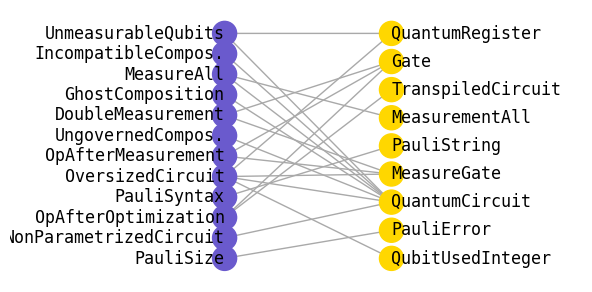

In [9]:
# create bipartite graph of abstractions and queries
import networkx as nx
import matplotlib.pyplot as plt


FONT_SIZE = 12
FONT_FAMILY = 'monospace'
fig, ax = plt.subplots(figsize=(6, 3))
# zoom out to make all the nodes visible
plt.xlim(-3, 3)
G = nx.DiGraph()

# use monospace font

# codeql color background: E8FAFC

# add all queries: color them #E8FAFC
for query_name in query_to_abstraction.keys():
    G.add_node(query_name, bipartite=1)


# add all abstractions: color them orange
for abstractions in query_to_abstraction.values():
    for abstraction in abstractions:
        G.add_node(abstraction, bipartite=0)

# add edges: directed from query to abstraction
for query_name, abstractions in query_to_abstraction.items():
    for abstraction in abstractions:
        G.add_edge(query_name, abstraction)
        
# place all abstractions on the left
pos = nx.bipartite_layout(G, nodes=[
    n 
    for n, d in G.nodes(data=True) 
    if d['bipartite'] == 1]
)


color_map = []
left_nodes = []
right_nodes = []
pos_left = {}
pos_right = {}
for node in G:
    if node in query_to_abstraction.keys():
        color_map.append('slateblue')
        left_nodes.append(node)
        pos_left[node] = pos[node]
    else:
        color_map.append('gold')
        right_nodes.append(node)
        pos_right[node] = pos[node]

G_left_nodes = G.subgraph(left_nodes)
G_right_nodes = G.subgraph(right_nodes)

nx.draw(
    G, pos=pos,
    node_color=color_map,
    arrowstyle='-',
    edge_color='darkgray',
    ax=ax
)
nx.draw_networkx_labels(
    G_left_nodes, pos=pos_left,
    font_size=FONT_SIZE,
    font_family=FONT_FAMILY,
    horizontalalignment='right'
)


nx.draw_networkx_labels(
    G_right_nodes, pos=pos_right,
    font_size=FONT_SIZE,
    font_family=FONT_FAMILY,
    horizontalalignment='left'
)


# for node in G:
#     print(node, pos[node])

# # get all the references to the text of the labels
# labels = {t.get_text(): t for t in ax.get_children() if isinstance(t, plt.Text)}

# # plot a letter and get the size of it when rendered
# t = plt.text(0, 0, 'A', fontsize=FONT_SIZE, family='monospace')
# char_width = t.get_window_extent().width / plt.gcf().dpi
# print("char_width: ", char_width)
# # remove the letter
# t.remove()




# # print their content and location
# for label, text in labels.items():
#     location = text.get_position()
#     print(label, location)
#     # remove it 
#     if label.strip() != '':
#         text.remove()
#     x, y = location
#     length = len(label)
#     base_distance = 1.5
#     if not label in query_to_abstraction.keys():
#         x_shift = base_distance * char_width 
#     else:
#         x_shift = - ((length) * char_width) 
#     new_x = x + x_shift
#     new_y = y
#     t = plt.text(
#         new_x,
#         new_y,
#         label,
#         fontsize=FONT_SIZE,
#         family='monospace',

#     )
#     t.set_clip_on(False)
plt.tight_layout(
    pad=1,
)
fig.savefig(
    os.path.join(PAPER_DIR, 'abstraction_graph.pdf'))


## RQ2: Real Bugs Found

In [32]:
# create latex table
from copy import deepcopy
import string

df_bugs = pd.read_csv(PATH_MANUAL_INSPECTION_CSV)
df_bugs = df_bugs.sort_values(by=[
    "status", "known_before"
], ascending=[True, False])
df_bugs = df_bugs.reset_index(drop=True)
df_bugs = df_bugs.reset_index(drop=False)
df_bugs = df_bugs.fillna("-")

ANONYMOUS = False
KEEP_ONLY_CONFIRMED = True 
KEEP_ONLY_CRASHES = True 
REMOVE_FALSE_POSITIVES = True
REMOVE_NOISY_WARNINGS = True
REMOVE_UNANNOTATED = True

col_renaming = {
    "index": "ID",
    "bug_id": "Bug ID",
    "bug_description": "Bug",
    "detector_rule": "Detector",
    #"API_usage": "API usage",
    "manifestation": "How",
    #"component": "Where",
    "link_to_issue": "Report",
    "status": "Status",
    #"known_before": "Novelty",
    #"triage": "Triage",
}

if ANONYMOUS:
    df_bugs["link_to_issue"] = "#XXXX"
else:
    df_bugs["link_to_issue"] = df_bugs["link_to_issue"].apply(
        lambda e: e.replace("https://github.com/Qiskit/qiskit-terra/issues/", "#")
    )

pd.set_option('display.max_colwidth', 1000)

relevant_columns = col_renaming.keys()
df_table = deepcopy(df_bugs)
if REMOVE_FALSE_POSITIVES:
    df_table = df_table[~(df_table["triage"] == "FP")]
if REMOVE_NOISY_WARNINGS:
    df_table = df_table[~(df_table["triage"] == "Noisy warning")]
if REMOVE_UNANNOTATED:
    df_table = df_table[~(df_table["triage"] == "-")]
df_table = df_table.drop(columns='index')  

# def replace_MR_names(transf_str):
#     new_transf_str = transf_str
#     for k, v in MR_ALIAS.items():
#         new_transf_str = new_transf_str.replace(k, v)
#     return new_transf_str

# df_table["mr_used"] = df_table["mr_used"].apply(
#     lambda e: replace_MR_names(transf_str=e)
# ) 


# replace fixed with the url and fixed
df_table["status"] = df_table["status"].apply(
    lambda e: "fixed" if "fixed" in e else e
)

df_table = df_table.reset_index(drop=True)
df_table = df_table.reset_index(drop=False)
df_table = df_table[relevant_columns].rename(columns=col_renaming)
df_table["ID"] = df_table["ID"].apply(lambda e: int(e) + 1)
# cut the column with detector
df_table["Detector"] = df_table["Detector"].apply(
    lambda e: e.replace("ql-", ""))

print("% RQ2")
for i, row in df_table.iterrows():
    msg = row["Bug"]
    msg = msg.translate(str.maketrans('', '', string.punctuation))
    msg = ''.join([w.capitalize() for w in msg.lower().split()])
    msg = ''.join(ch for ch in msg if ch.isalpha())
    if msg != "":
        print("\\newcommand{\\ID" + msg + "}{" + str(row["ID"]) + "}")

print("")
table_code = df_table.to_latex(
    column_format='@{}rlp{7.3cm}p{2.5cm}lll@{}',
    index=False)
table_code = re.sub("\s'", " `", table_code)
# replace all links with a \url{} command
table_code = re.sub("(https:[^ ]*)", r"\\href{\1}{link}", table_code)
print(table_code)
df_table

% RQ2
\newcommand{\IDBugGhostComposeInTestldmcuA}{1}
\newcommand{\IDBugGhostComposeInTestldmcuB}{2}
\newcommand{\IDBugShorAlgoMissingInsertionOfTheInverseQft}{3}
\newcommand{\IDBugMeasurementAfterTranspilationLevel}{4}
\newcommand{\IDBugConsumingDoubleOfTheSpaceNeeded}{5}
\newcommand{\IDBugUnwantedAdditionOfClassicalBitsViaMeasureall}{6}
\newcommand{\IDBugMissingCircuitReinitializationInOrImplementation}{7}
\newcommand{\IDBugUnusedQubit}{8}
\newcommand{\IDBugIbmqTokenSecretLeakage}{9}

\begin{tabular}{@{}rlp{7.3cm}p{2.5cm}lll@{}}
\toprule
 ID &         Bug ID &                                                         Bug &              Detector &           How &                                                                               Report &   Status \\
\midrule
  1 &   06\_13ba80\_90 &                        BUG: ghost compose in test\_ldmcu (A) &         ghost-compose &        silent &                                            \href{https://github.com/qclib/qclib/issues/139}{li

/tmp/ipykernel_22568/3235937746.py:87: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_code = df_table.to_latex(


,ID,Bug ID,Bug,Detector,How,Report,Status
0,1,06_13ba80_90,BUG: ghost compose in test_ldmcu (A),ghost-compose,silent,https://github.com/qclib/qclib/issues/139,fixed
1,2,06_13ba80_107,BUG: ghost compose in test_ldmcu (B),ghost-compose,silent,https://github.com/qclib/qclib/issues/139,fixed
2,3,06_df608f_322,BUG: Shor algo: missing insertion of the inverse qft,ghost-compose,silent,https://github.com/fastflair/Tutorials/issues/14,reported
3,4,06_c4c34f_45,BUG: measurement after transpilation level 3,op-after-optimization,silent,https://github.com/DiracMG3/Circuit-Optimization-for-Hamiltonian-Simulation/issues/1,reported
4,5,06_09be03_19,BUG: consuming double of the space needed,measure-abuse,longer output,https://github.com/tula3and/qoupang/issues/1,reported
5,6,06_55fd07_25,BUG: unwanted addition of classical bits via `measure_all`,measure-abuse,longer output,https://github.com/0tt3r/QuaC-qiskit/issues/1,reported
6,7,06_17fe47_18,BUG: missing circuit re-initialization in OR implementation,op-after-measurement,silent,https://github.com/shantanu-misra/Quantum_coumputing_with_Qiskit/issues/1,reported
7,8,06_4c9443_35,BUG: unused qubit,oversized-circuit,-,https://github.com/beaudoco/qiskit-shifting-simulator/issues/1,reported
8,9,06_4c9443_11,BUG: IBMQ token secret leakage,token-leakage,-,https://github.com/beaudoco/qiskit-shifting-simulator/issues/2,reported
9,10,06_c4c34f_40,-,op-after-optimization,silent,-,-


## RQ3: False Positives Found

### RQ3.A: How many warnings are generated per query?

In [10]:
PATH_WARNINGS_CSV_NEW = PATH_WARNINGS_SARIF.replace(".sarif", ".csv")
PATH_WARNINGS_CSV_NEW

'../data/analysis_results/exp_v08/codeql_2023-03-13_13-54-00/data.csv'

In [35]:
! sarif csv --output {PATH_WARNINGS_CSV_NEW} {PATH_WARNINGS_SARIF}

Writing CSV summary for data.sarif to data.csv


In [11]:
df_metadata = pd.read_csv(PATH_METADATA_DATASET)
print(df_metadata.columns)
df_metadata['unique_id'] = df_metadata.apply(
    lambda row: str(row['filestem']) + "_" + str(row['hash']),
    axis=1
)
df_metadata = df_metadata[['unique_id', 'extension', 'repository_name']]
df_metadata.head()

Index(['download_url', 'html_url', 'name', 'path', 'repository_description',
       'repository_fork', 'repository_name', 'repository_owner_url',
       'repository_url', 'score', 'filename', 'extension', 'filestem', 'hash',
       'unique_id'],
      dtype='object')


,unique_id,extension,repository_name
0,test_sabre_swap_95cbde,py,sethuquantum/LearnQuantum
1,B01_Qiskit_Reference-checkpoint_9b754a,ipynb,QRussia/basics-of-quantum-computing-translate
2,quantum_generator_d6f5f2,py,roytu/QOSF-FeMoco2020
3,B01_Qiskit_Reference_c78ae2,ipynb,Abdoelabassi/Qbronze
4,pulse_instruction_f43374,py,904194705/Qiskit-RIKEN-project-


In [57]:
df_warnings = pd.read_csv(PATH_WARNINGS_CSV_NEW)
df_warnings['rule'] = df_warnings['Code'].apply(lambda e: e.split(" ")[0])
df_warnings['unique_id'] = df_warnings['Location'].apply(lambda e: e.split(".")[0])
df_warnings.head()

,Tool,Severity,Code,Location,Line,rule,unique_id
0,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (1012, 9) and (1012, 9)",five_qubit_stabilizer_728e76.py,1012,ql-double-measurement,five_qubit_stabilizer_728e76
1,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (1013, 9) and (1013, 9)",five_qubit_stabilizer_728e76.py,1013,ql-double-measurement,five_qubit_stabilizer_728e76
2,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (1014, 9) and (1014, 9)",five_qubit_stabilizer_728e76.py,1014,ql-double-measurement,five_qubit_stabilizer_728e76
3,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (1015, 9) and (1015, 9)",five_qubit_stabilizer_728e76.py,1015,ql-double-measurement,five_qubit_stabilizer_728e76
4,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (102, 9) and (102, 9)",seven_qubit_stabilizer_4347a9.py,102,ql-double-measurement,seven_qubit_stabilizer_4347a9


In [58]:
# merge the two dataframes keeping the df_warnings as the base
df_merged = pd.merge(
    df_warnings,
    df_metadata,
    on='unique_id',
    how='left'
)
df_merged.head()

,Tool,Severity,Code,Location,Line,rule,unique_id,extension,repository_name
0,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (1012, 9) and (1012, 9)",five_qubit_stabilizer_728e76.py,1012,ql-double-measurement,five_qubit_stabilizer_728e76,py,gwjacobson/QuantumErrorCorrection
1,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (1013, 9) and (1013, 9)",five_qubit_stabilizer_728e76.py,1013,ql-double-measurement,five_qubit_stabilizer_728e76,py,gwjacobson/QuantumErrorCorrection
2,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (1014, 9) and (1014, 9)",five_qubit_stabilizer_728e76.py,1014,ql-double-measurement,five_qubit_stabilizer_728e76,py,gwjacobson/QuantumErrorCorrection
3,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (1015, 9) and (1015, 9)",five_qubit_stabilizer_728e76.py,1015,ql-double-measurement,five_qubit_stabilizer_728e76,py,gwjacobson/QuantumErrorCorrection
4,CodeQL,warning,"ql-double-measurement Two consecutive measurements on qubit 'IntegerLiteral' at locations: (102, 9) and (102, 9)",seven_qubit_stabilizer_4347a9.py,102,ql-double-measurement,seven_qubit_stabilizer_4347a9,py,gwjacobson/QuantumErrorCorrection


Text(0, 0.5, 'Detector')

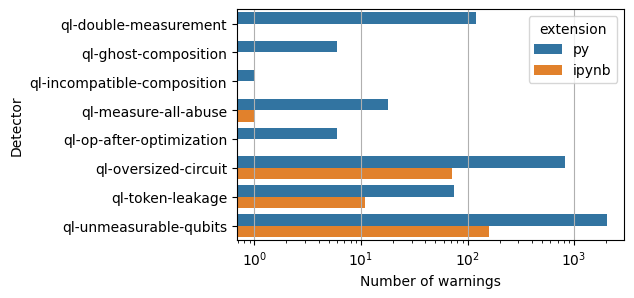

In [54]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.countplot(
    data=df_merged,
    y='rule',
    hue='extension',
)
# set log scale
plt.xscale('log')
# switch on axix
plt.gca().xaxis.grid(True)
plt.xlabel("Number of warnings")
plt.ylabel("Detector")

### RQ3.B False Positive Estimate (via samples)

In [15]:
BLACKLIST_EXPERIMENTS = ['exp_v00']

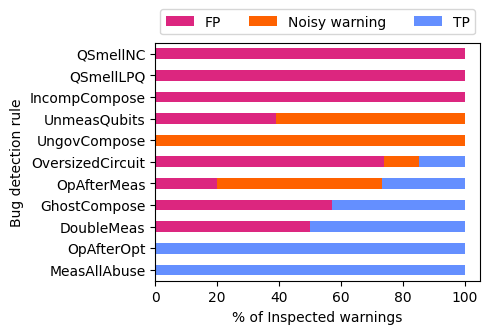

In [39]:
df_inspected_warnings = pd.read_csv(PATH_MANUAL_INSPECTION_CSV)
# filter out blacklisted experiment
df_inspected_warnings = df_inspected_warnings[
    ~df_inspected_warnings["experiment"].isin(BLACKLIST_EXPERIMENTS)]
# filter out blacklisted
df_inspected_warnings = df_inspected_warnings[
    ~df_inspected_warnings["detector_rule"].isin(BLACKLISTED_RULES)]
# map the rules with the name mapping
df_inspected_warnings['detector_rule'] = \
    df_inspected_warnings['detector_rule'].map(RULE_NAME_MAPPING)
# drop all rows with nan in the experiment column
df_inspected_warnings = df_inspected_warnings.dropna(subset=['experiment'])


cross_tab_prop = pd.crosstab(
    index=df_inspected_warnings['detector_rule'],
    columns=df_inspected_warnings['triage'],
    normalize="index")

cross_tab_prop = cross_tab_prop * 100
# sort by number of TP column 
cross_tab_prop = cross_tab_prop.sort_values(by=["TP", "Noisy warning"], ascending=False)

fig, ax = plt.subplots(figsize=(5, 3.5))
cross_tab_prop.plot(
    kind='barh', 
    stacked=True, 
    color=['#DC267F', '#FE6100', '#648FFF'],
    ax=ax
)
plt.xlabel("% of Inspected warnings")
plt.ylabel("Bug detection rule")
# put legend above the diagram
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=3)
plt.tight_layout()
fig.savefig(
    os.path.join(PAPER_DIR, "precision_estimate.pdf"), 
    bbox_inches="tight")


In [30]:
list(df_inspected_warnings['detector_rule'].unique())

['ql-ghost-compose',
 'ql-measure-all-abuse',
 'ql-operation-after-measurement',
 'ql-op-after-optimization',
 'ql-oversized-circuit',
 'ql-double-measurement',
 'ql-unmeasurable-qubits',
 'ql-ungoverned-composition',
 'ql-incompatible-composition',
 'qsmell-nc',
 'qsmell-lpq']